In [114]:
## Imports
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
plt.rcParams["figure.figsize"] = (20,10)

In [116]:
df_patient = pd.read_csv("australia_covid_no_dup.csv")
df_pcr = pd.read_csv("clean_pcr.csv")

# Exploratory Data Analysis

Pour analyser ces données maintenant qu'elles ont été nettoyées, on va commencer par établir les questions auxquelles on voudrait répondre :

- quelle est la prévalence de la maladie dans la population entière ?
- quelle est la prévalence de la maladie selon les âges ?
- quelle est la prévalence de la maladie géographiquement ?


On commence par joindre les deux bases de données grâce à la valeur de `patient_id`.



    EDA to do

    Visualization

    - camembert pos/neg total
    - age
        - ratio pos/neg by age
        - total pos/neg by age
    - state
        - same
        - and same
        - and map w/ geopandas if time allows?

In [117]:
full_df = df_patient.merge(df_pcr, on="patient_id", how="inner")

In [118]:
print(full_df.columns, len(full_df))

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'patient_id', 'given_name', 'surname',
       'street_number', 'address_1', 'address_2', 'suburb', 'postcode',
       'state', 'state_corrected', 'date_of_birth', 'dob_date', 'age',
       'age_inferred', 'test_year', 'phone_number', 'phone_format',
       'phone_geo', 'all_info', 'processed', 'original', 'group',
       'Unnamed: 0_y', 'pcr'],
      dtype='object') 8632


## 1. Prévalence de la maladie dans la population totale

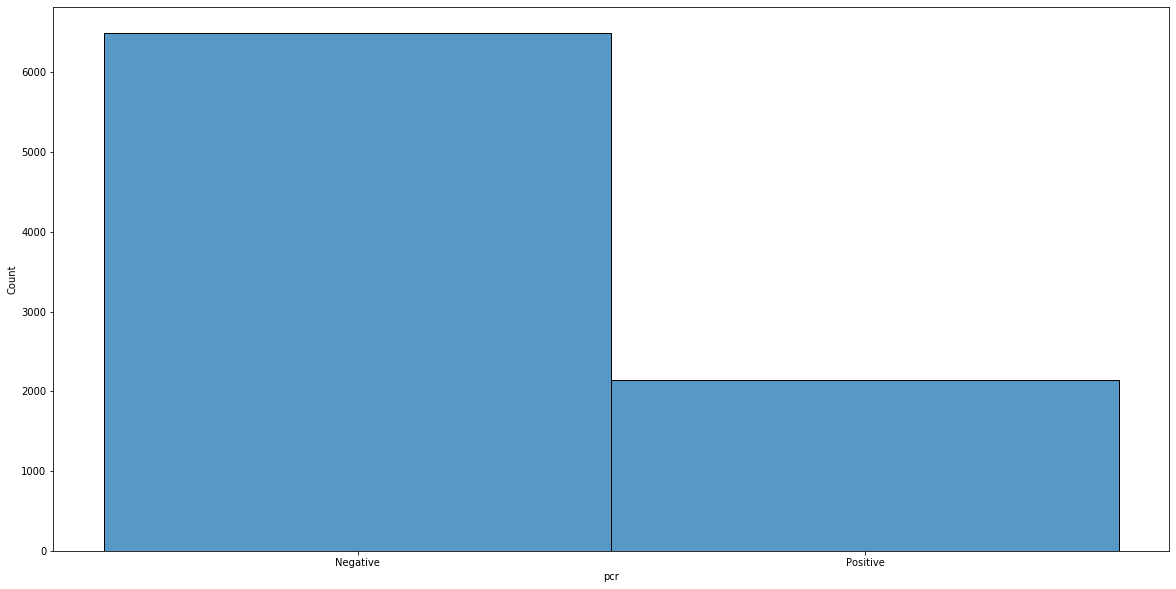

In [119]:
sns.histplot(data = full_df, x="pcr")

Sur l'ensemble de la population, on compte trois fois plus de tests négatifs que de tests positifs.

## 2. Prévalence de la maladie selon les âges

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


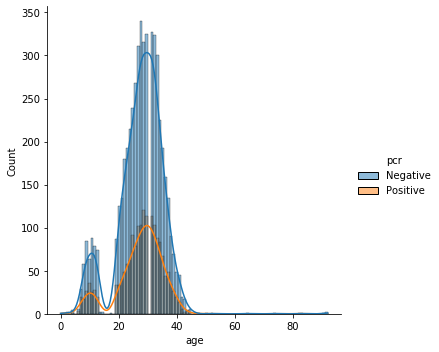

In [120]:
sns.displot(data=full_df, x="age", hue="pcr", kde=True)

Il ne semble pas y avoir un âge auquel la maladie est prévalente, la courbe suit la tendance du nombre de tests réalisés.

## 3. Prévalence de la maladie selon la localisation géographique

state_corrected
act    0.258621
nsw    0.244874
nt     0.098039
qld    0.250812
sa     0.222037
tas    0.262009
vic    0.262827
wa     0.253772
dtype: float64

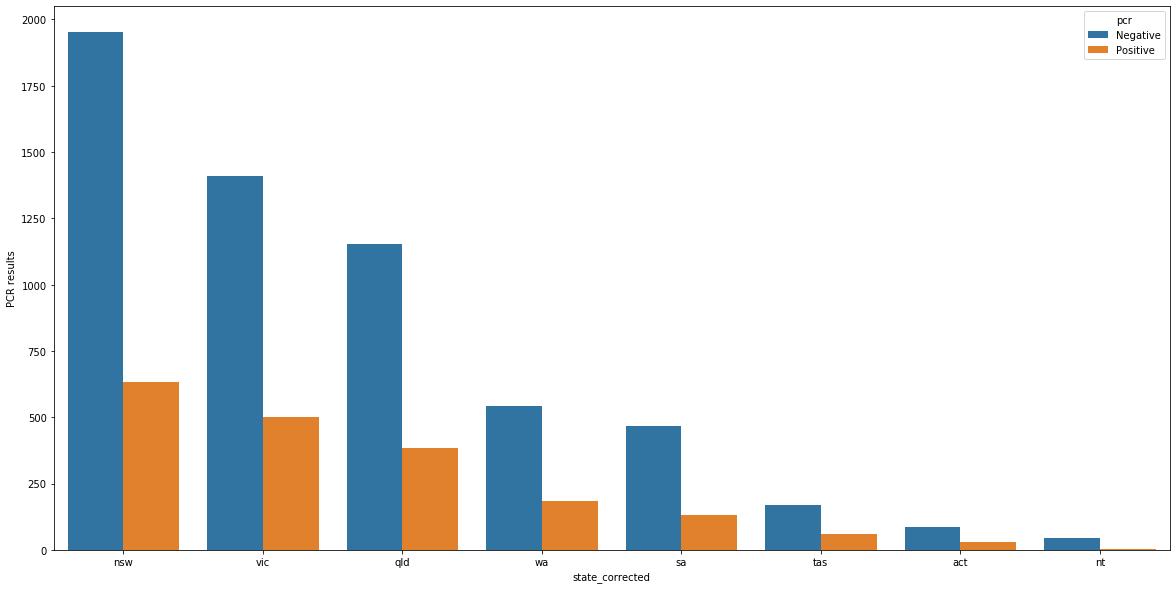

In [121]:
(full_df.state_corrected
 .groupby(full_df.pcr)
 .value_counts()
 .rename("PCR results")
 .reset_index()
 .pipe((sns.barplot, "data"), x="state_corrected", y="PCR results", hue="pcr"))

full_df["result_pcr"] = full_df.apply(lambda row: 0 if row.pcr in ["N", "Negative"] else 1, axis=1)

(full_df
.groupby("state_corrected")
.aggregate({"result_pcr": "sum", "patient_id": "count"})
.apply(lambda row: row["result_pcr"]/row["patient_id"], axis=1))



La tendance semble être la même dans tous les états d'Australie avec environ 25% des tests qui reviennent positifs, sauf peut-être dans NT mais c'est sûrement dû au nombre très limité de tests dans cet état. On peut aussi regarder les tests par état et par âge.

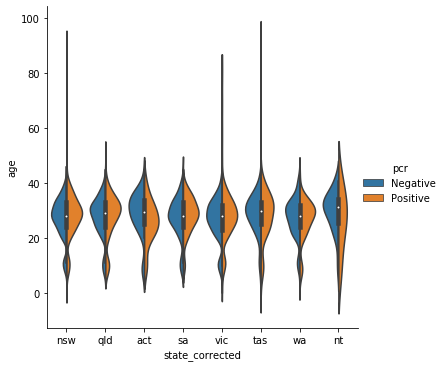

In [122]:
sns.catplot(data=full_df, kind="violin", x="state_corrected", y="age", hue="pcr", split=True)

Encore une fois, il n'y a pas de différences significatives entre la répartition des résultats de PCR par âge par état, à part:

- toujours NT, ce qui peut être dpu au nombre limité de points de contrôle
- ACT, qui semble avoir une légère dissymétrie dans les résultats, les plus jeunes (20-25) ayant une proportion de tests positifs plus grande que les 30-40 ans.